# **Cambio runtime -> GPU**

# **Importo librerie**

In [ ]:
# Import TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
import pandas as pd
import numpy as np
import pathlib
from matplotlib import pyplot as plt
import random
import numpy
from time import time
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers,models,initializers
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from keras.wrappers.scikit_learn import KerasClassifier
import operator
from operator import itemgetter
from PIL import Image
keras.__version__

import shutil


%matplotlib inline 

from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Caricamento dataset**

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228827136/228813984 [==============================] - 1s 0us/step


In [ ]:
data_dir=pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [ ]:
num_classes=5

# **Controllo bilanciamento classi**

Contiamo il numero di immagini per ciascuna delle 5 classi:

Il dataset contiene 3670 immagini



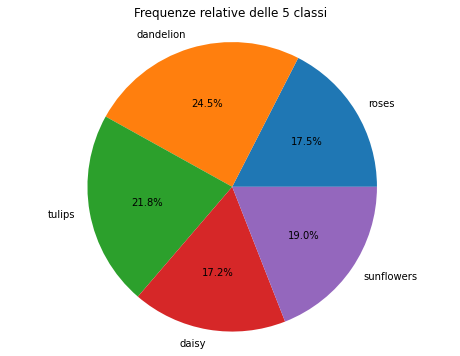

In [ ]:
os.remove("/content/datasets/flower_photos/LICENSE.txt")

dir= "/content/datasets/flower_photos"

dataframe= pd.DataFrame(columns=['classe','n'])

dataframe['classe']=pd.Series([os.listdir(dir)[x] for x in range(0,5)])

dataframe['n']=pd.Series([len(os.listdir(os.path.join(dir,os.listdir(dir)[x]))) for x in range(0,5)])

num_img=0
for i in range(0,5):
  num_img=num_img+dataframe['n'].loc[i]


print(f"Il dataset contiene {num_img} immagini\n")

plt.figure(figsize=(8,6))
plt.tight_layout()
plt.pie(dataframe['n'],
        labels=dataframe['classe'],
        autopct='%1.1f%%')
plt.axis('equal')
plt.title( "Frequenze relative delle 5 classi")
plt.show()

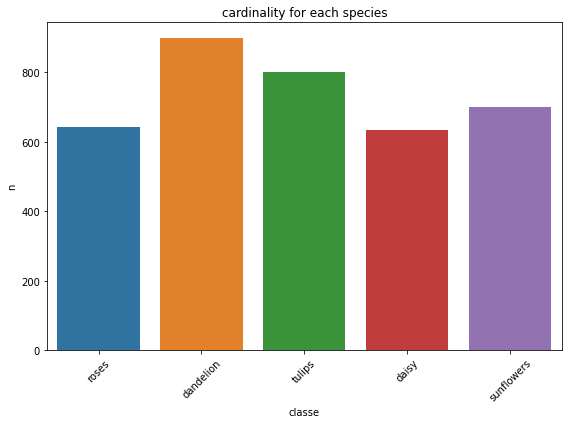

In [ ]:
plt.figure(figsize=(8,6))
g = sns.barplot(x='classe', y = 'n', data=dataframe)
g.set_xticklabels(g.get_xticklabels(), rotation =45)
plt.title('cardinality for each species')
plt.tight_layout()

Come si può osservare le classi sono piuttosto bilanciate (hanno cardinalità simili). Ciò rappresenta un vantaggio, infatti se avessi un forte sbilanciamento delle classi andrei a creare un bias nel training poiché la rete sarebbe molto più allenata a riconoscere le classi con più rappresentanti rispetto alle altre (basterebbe ciò a garantire buone performance su train e validation set)  


# **Visualizzazione di alcune immagini del dataset**

Di seguito vengono mostrate alcune delle immagini presenti nel dataset.
Si può notare come i soggetti dell'indagine (fiori) non siano gli unici elementi presenti, ma vi sono anche altri elementi che ne fanno da contorno. 

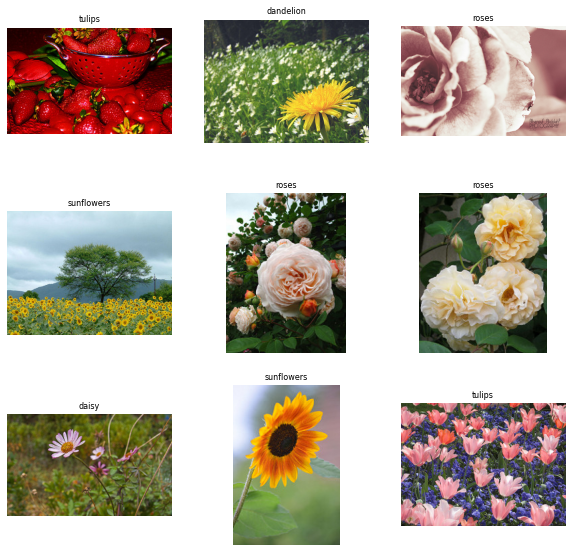

In [ ]:
classes = ["daisy",  "dandelion", "roses", "sunflowers" , "tulips"]

W = 3
H = 3
fig, axes = plt.subplots(W, H, figsize = (10,10))
axes = axes.ravel() 

for i in np.arange(0, 9):
  label = random.choice(classes)
  class_dir = os.path.join(dir,label)    
  image = random.choice(os.listdir(class_dir))
  img = plt.imread(os.path.join(class_dir,image))
  axes[i].imshow( img )
  axes[i].set_title(label, fontsize = 8) 
  axes[i].axis('off')


# **Decisione dimensioni immagini**

In [ ]:
classes = dataframe['classe'].tolist()

for i in range(0, 10):
  label = random.choice(classes)
  class_dir = os.path.join(dir,label)    
  image = random.choice(os.listdir(class_dir))
  img = plt.imread(os.path.join(class_dir,image))
  print(label,img.shape)


daisy (375, 500, 3)
dandelion (240, 159, 3)
tulips (240, 180, 3)
tulips (214, 320, 3)
sunflowers (332, 500, 3)
sunflowers (240, 180, 3)
daisy (414, 500, 3)
roses (226, 320, 3)
roses (240, 320, 3)
roses (333, 500, 3)


Come si può osservare, le immagini del dataset hanno dimensioni diverse (anche immagini appartenenti alla stessa classe). Sappiamo però che le immagini utilizzate in una CNN devono avere tutte le stesse dimensioni, quindi dovremo settare un formato comune per tutte le immagini e ciò porterà inevitabilmente ad avere immagini adattate ad un formato non loro e quindi leggermente sproporzionate. Per quanto riguarda i colori, sono tutte nel formato RGB

Ricaviamo ora l'altezza e la larghezza media delle immagini del dataset, in modo da poter decidere un formato unico delle immagini che modifichi mediamente il meno possibile il formato delle immagini

In [ ]:
lista_larghezze=[]
lista_altezze=[]

for i, row in dataframe.iterrows():

  label=row['classe']
  class_dir = os.path.join(dir,label)
  lista_immagini=os.listdir(class_dir)


  for image in lista_immagini:
    img = plt.imread(os.path.join(class_dir,image))
    lista_larghezze = lista_larghezze + [img.shape[0]]
    lista_altezze = lista_altezze + [img.shape[1]]

lista_rapporti=[]
for i in range(0,len(lista_larghezze)):
  lista_rapporti.append(lista_altezze[i]/lista_larghezze[i])

print(f"Larghezza media: {sum(lista_larghezze)/len(lista_larghezze)}")
print(f"Altezza media: {sum(lista_altezze)/len(lista_altezze)}")
print(f"Rapporto altezza/larghezza medio: {sum(lista_rapporti)/len(lista_rapporti)}")

Larghezza media: 271.79128065395093
Altezza media: 365.0623978201635
Rapporto altezza/larghezza medio: 1.3272975468815498


Questo primo approccio però non considera le distribuzioni di tali misure. Analizziamole aiutandoci con dei grafici:

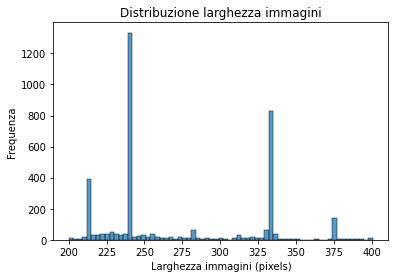

In [ ]:
fig,ax1 = plt.subplots()
sns.histplot(lista_larghezze, binwidth=3, binrange=(200,400))
ax1.set_xlabel("Larghezza immagini (pixels)")
ax1.set_ylabel("Frequenza")
ax1.set_title("Distribuzione larghezza immagini");
#Le immagini hanno principalemte larghezza pari a 240 0 335 circa

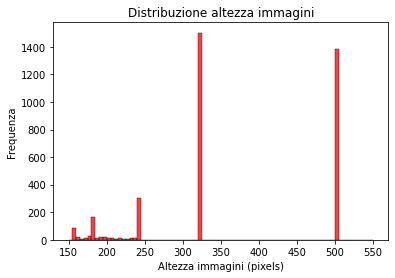

In [ ]:
fig,ax1 = plt.subplots()
sns.histplot(lista_altezze, binrange = (150,550), color='r', binwidth=5)
ax1.set_xlabel("Altezza immagini (pixels)")
ax1.set_ylabel("Frequenza")
ax1.set_title("Distribuzione altezza immagini");
#Le immagini hanno principalmente altezza pari a 320 o 500

Analizziamo ora la distribuzione del rapporto altezza/larghezza:

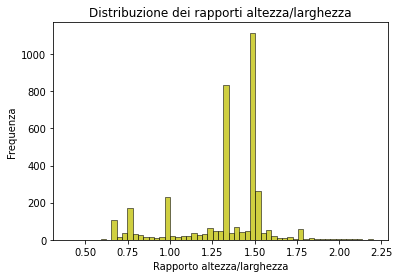

In [ ]:
fig,ax1 = plt.subplots()
sns.histplot(lista_rapporti, color='y', binrange = (0.4,2.2));
ax1.set_xlabel("Rapporto altezza/larghezza")
ax1.set_ylabel("Frequenza")
ax1.set_title("Distribuzione dei rapporti altezza/larghezza");
#Le immagini hanno principalmente un rapporto altezza/larghezza di circa 1.32 
#o 1.49 (corrispondenti a 320/240 o 500/335)

Dopo tutte queste considerazioni la scelta del formato delle immagini ricade tra 240x320 o 335x500. Abbiamo optato per usare il formato 240x320 per 3 motivi:


1.   Le immagini 240x320 sono più numerose di quelle 335x500
2.   Il formato 240x320 è più piccolo del 335x500, e ipotizziamo che ai fini del training sia meglio rimpicciolire delle immagini piuttosto che sgranarle
3.   Il formato 240x320 si avvicina più ai valori medi calcolati precedentemente rispetto al formato 335x500

# **Hyperparameter tuning e scelte per i modelli**

**Maxpooling**

Per i layers di pooling abbiamo deciso di utilizzare Maxpooling e non Avgpooling. Tale scelta deriva dal fatto che Avgpooling, calcolando delle medie locali non consente di identificare le feature più nitide e più luminose dell'immagine, a nostro avviso fondamentali per l'identificazioni di fiori.
Maxpooling permette inoltre di distinguere meglio parti del fiore dallo sfondo, poco importante nella distinzione tra tipi diversi di fiori.

**LOSS: categorical crossentropy**

Come funzione di costo abbiamo optato per la categorical crossentropy, la più usata per la classificazione non binaria. Essa riesce bene ad esprimere quanto due distribuzioni di probabilità discrete siano distinte. I nostri modelli cercheranno di imparare a dare una maggiore probabilità di appartenenza di un'immagine alla classe corretta (e una probabilità inferiore per le altre classi). Utilizzeremo anche l'accuracy come metrica aggiuntiva (senza ottimizzarla).

**Softmax**

Se viene usata come funzione di costo la categorical crossentropy l'attivazione da usare per il layer di output è softmax, che ha lo scopo di produrre una pseudo distribuzione di probabilità (infatti si assicura che la somma dei 5 valori rappresentati le probabilità che l'immagine appartenga a ogni classe sia pari a 1).

**Optimizer: RMSprop e Adam**

Abbiamo scelto di utilizzare gli algoritmi di ottimizzazione 'RMSprop' e successivamente 'Adam' per cercare di evitare il problema del vanishing o exploding gradient (che porterebbe alla mancata convergenza in tempi utili del modello). Essi infatti, a differenza dell'algoritmo SGD, creano un learning rate diverso per ogni peso in modo da poter mantenere ogni peso entro range accettabili. Abbiamo utilizzato il learning rate di default (pari **0.001**) e successivamente pari a a **0.005** in quanto ci è sembrato un giusto compromesso tra il learning rate 0.001 (che dava una convergenza troppo lenta) e 0.01.


**Batchsize**

Abbiamo fissato la batchsize a **32**. Durante il corso abbiamo infatti visto come utlizzare un'ottimizzazione a batch sia più efficiente di updatare ogni volta il gradiente in base a tutte le osservazioni del training test (perché in ogni epoca vengono fatti più update), ma anche come utilizzare solo un'osservazione a batch possa far oscillare i valori di costo più del dovuto. Sull'ultima rete abbiamo provato tre batchsize diverse (**16**,**32**,**64**) implementando una procedura di selezione del valore migliore (attraverso un'ulteriore suddivisione del training set per non creare forti bias) tramite l'algoritmo Gridsearch. Abbiamo inserito solo 3 opzioni di batchsize e 10 epoche perché questo algoritmo è molto computationally demanding e aumentare tali numeri porterebbe l'algoritmo a non completare l'esecuzione in tempi utili.

**Epoche e callback**

Il numero di epoche (cioè quante volte viene usato l'intero training set per updatare i pesi nel processo di training) è stato fissato a **50** e successivamente a **60**. Abbiamo deciso di utilizzare processi di callback per arrestare il training nel caso non ci siano stati miglioramenti nelle ultime **15** epoche ed evitare così overfitting. 

**Weight initialization**

La modalità di inizializzazione dei pesi indicata utilizzando le activation functions sopra citate è '**he_uniform**'. Essa determina i pesi con delle estrazioni da una distribuzione uniforme su un intervallo dipendente dal numero di pesi.



# **Definizione del training e del test set**

Abbiamo deciso di utilizzare lo split **0.8**-**0.2** per la creazione di training e validation set, con shuffle=True per poter considerare tali insiemi campioni indipendenti della stessa distribuzione di probabilità. Dobbiamo anche impostare lo stesso seed (=1) in modo che siano effettivamente due insiemi complementari.

In [ ]:
base_path = 'datasets/flower_photos/'

In [ ]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(base_path,
                                                                   image_size= (240,320),
                                                                   batch_size = 32,
                                                                   label_mode = 'categorical',
                                                                   color_mode = 'rgb',
                                                                   subset = 'training',
                                                                   validation_split = 0.2,
                                                                   shuffle =True,
                                                                   seed = 1)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
validation_set = tf.keras.preprocessing.image_dataset_from_directory(base_path,
                                                                   image_size= (240,320),
                                                                   batch_size = 32,
                                                                   label_mode = 'categorical',
                                                                   color_mode = 'rgb',
                                                                   subset = 'validation',
                                                                   validation_split = 0.2,
                                                                   shuffle =True,
                                                                   seed = 1)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Dal training set appena creato creiamo gli array contenenti i dati di input e gli output (le classi), che utilizzeremo in seguito

In [ ]:
train_ds = training_set.unbatch()
x_train = np.asarray(list(train_ds.map(lambda x, y: x)))
y_train = np.asarray(list(train_ds.map(lambda x, y: y)))

# **RETE 1**

La prima rete è composta da:

- 3 strati convoluzionali con filtri 32, 64 e 128 di dimensione 3x3
- 3 strati di attivazione che usano la funzione 'relu'
- 2 strati di MaxPooling2D con finetre 3x3 e stride pari a 3
- 1 strato di GlobalMaxPooling2D 
- 1 uno strato Dense con funzione di attivazione 'softmax'

In [ ]:
inputs = keras.Input((240,320,3)) # righe, colonne, canali (nel nostro caso 3 x immagini RGB)

x = inputs


x = keras.layers.Conv2D(32, 3, padding="same")(x)  # 32 filtri di dimensione 3x3; Il padding aggiungere una "cornice" all'immagine in modo che l'immagine venga analizzata per intero durante convoluzione
x = keras.layers.Activation('relu')(x) # layer che introduce non linearità: il passaggio  tra input e output non avviene per mezzo di una semplice combinazione lineare ma crea un livello di complessità e astrazione maggiore
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x) #finestre 3x3 e stride pari a 3; ogni 3x3 valori di input vengono sostituiti con il valore max, successivamente si sposta la finestra di 3 pixel a destra.


x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x) # al posto di una finestra 3x3, utilizza una finestra grande quanto  l'intera attivazione del layer precedente

outputs = keras.layers.Dense(num_classes, activation='softmax')(x) #fully connected (in keras dense): 
                                                                   # ha un'attivazione softmax, quest'ultima prende i due numeri  restituiti dal layer dense e li da in input ad una funzione che ha lo scopo di produrre una 
                                                                   # pseudo distribuzione di probabilità (si assicura che la somma dei due valori sia pari a 1).  

net1 = keras.Model(inputs, outputs)

Nella fase di compilazione della rete si è optato per l'uso della funzione di loss categorical_crossentropy, dell'ottimizzatore RMSprorp con learning rate pari a 0.001 e della metrica 'accuracy'.

In [ ]:
net1.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

Infine, nella fase di fit del modello è stato deciso di eseguire 50 iterazioni e di usare la funzione di callback impostata a 15 epoche.

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 15)

In [ ]:
t0 = time()

history = net1.fit(training_set,
          epochs=50,
          validation_data=validation_set,
          callbacks = [callback]);

print("completed in %0.3f seconds" % (time() - t0) )

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

Dal grafico si evince che la rete presenta gravi problemi di overfitting e scarsi valori di accuracy nel validation set i quali implicano una bassa capacità di classificare correttamente le immagini.

Di seguito viene mostrata la struttura della rete.

In [ ]:
plot_model(net1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
net1.save('net1')

# **RETE 2**

Nella seguente rete è stata usata la medesima architettura di quella precedente con l'aggiunta degli strati:

- BatchNormalization: applica una trasformazione che mantiene la media dell'output vicina a 0 e la sua deviazione standard vicina a 1.
- Dropout: pone randomicamente delle unità di input pari a 0 durante la fase di training prevenendo così l'overfitting.  
- Flatten: rimodella il tensore rimuovendo tutte le dimensioni eccetto una.

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 15)

In [ ]:
inputs = keras.Input((240,320,3))

x = inputs


x = keras.layers.Conv2D(32, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x) # riporta i dati sempre entro un certo range, in modo tale che abbiano una distribuzione con media nulla e varianza unitaria
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.50) (x)

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Conv2D(128, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Flatten()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net2 = keras.Model(inputs, outputs)

In [ ]:
net2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
t0 = time()

history = net2.fit(training_set,
          epochs=50,
          validation_data=validation_set,
          callbacks = [callback]);

print("completed in %0.3f seconds" % (time() - t0) )

Epoch 1/50
46/46 [==============================] - 12s 213ms/step - loss: 1.9732 - accuracy: 0.3689 - val_loss: 1.8509 - val_accuracy: 0.3747
Epoch 2/50
46/46 [==============================] - 11s 210ms/step - loss: 1.2120 - accuracy: 0.5126 - val_loss: 1.8277 - val_accuracy: 0.3460
Epoch 3/50
46/46 [==============================] - 11s 209ms/step - loss: 1.0846 - accuracy: 0.5712 - val_loss: 1.6328 - val_accuracy: 0.3719
Epoch 4/50
46/46 [==============================] - 11s 210ms/step - loss: 1.0116 - accuracy: 0.6015 - val_loss: 1.2581 - val_accuracy: 0.5136
Epoch 5/50
46/46 [==============================] - 10s 208ms/step - loss: 0.9769 - accuracy: 0.6209 - val_loss: 0.9655 - val_accuracy: 0.6362
Epoch 6/50
46/46 [==============================] - 10s 209ms/step - loss: 0.9028 - accuracy: 0.6550 - val_loss: 1.3688 - val_accuracy: 0.5531
Epoch 7/50
46/46 [==============================] - 11s 209ms/step - loss: 0.8800 - accuracy: 0.6686 - val_loss: 1.1591 - val_accuracy: 0.5763

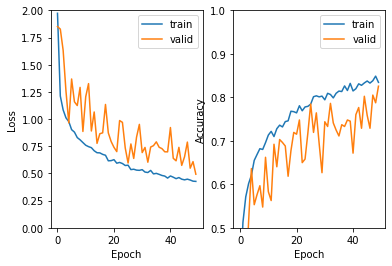

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

Dal grafico si può notare come l'introduzione di questi nuovi strati abbia comportato un incremento dei valori di accuracy nel validation set e una diminuzione dell'overfitting. Tuttavia i valori ottenuti non sono ancora soddisfacenti e il modello può essere migliorato. 



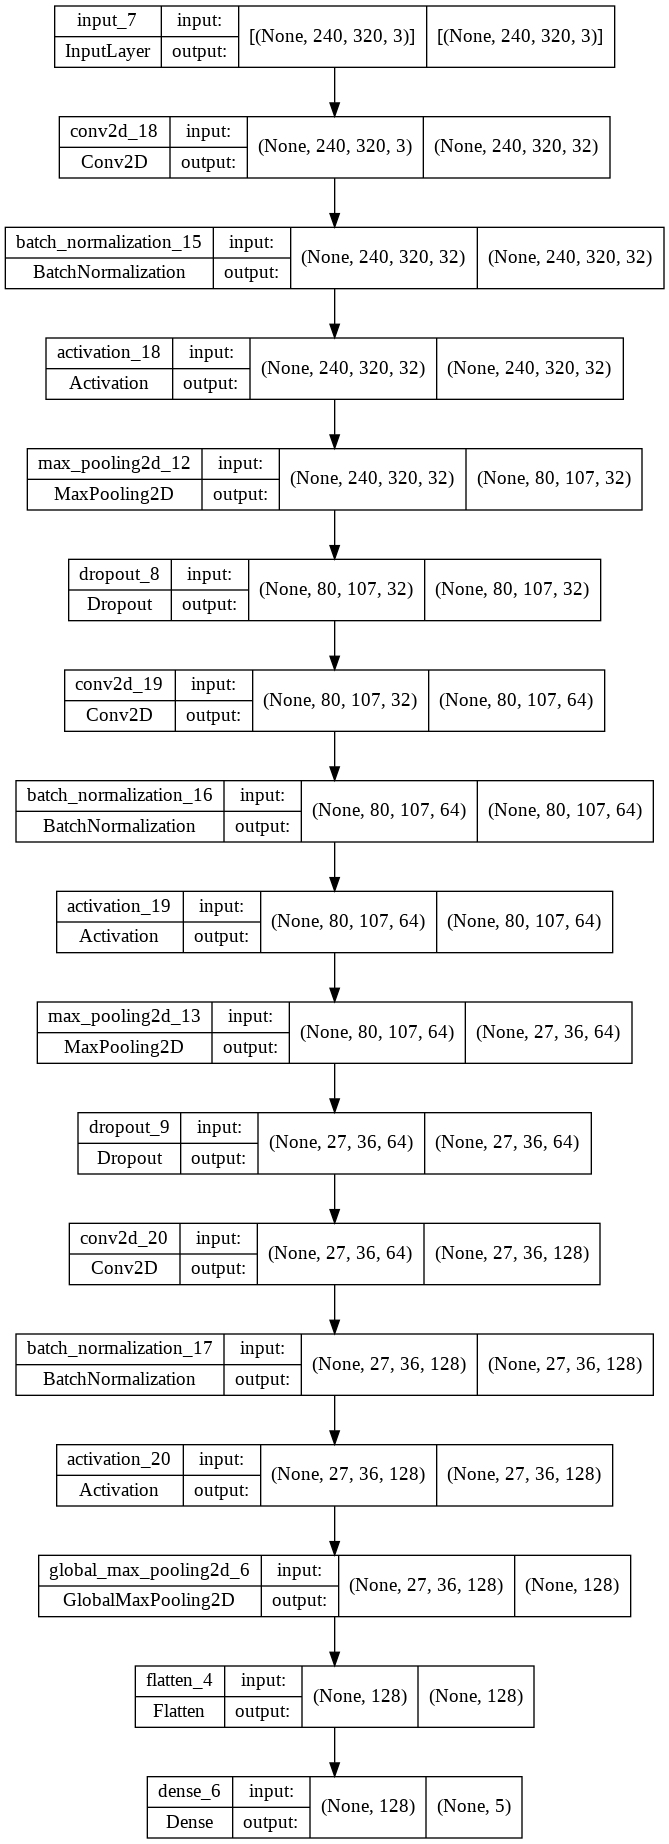

In [ ]:
plot_model(net2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
net2.save('net2')

# **RETE 3**

Nella terza architettura è stato modificato la funzione di attivazione, sostituendo la ReLU con la LeakyReLU perchè la ReLU restituisce un output pari a 0 in corrispondenza di input negativi. 
Inoltre viene modificata la funzione di ottimizzazione sostituendo la RMSprop con l'Adam, che presenta un learning rate pari a 0.005. 
Infine il rate del dropout viene aumentato da 0.50 a 0.55

Abbiamo inoltre delle trasformazioni geometriche di immagine (**data augmentation**) per cercare di migliorare le performance sul validation set inserendo riducendo l'overfitting. In particolare abbiamo eseguito dei ribaltamenti orizzontale seguiti da rotazioni che variano da -2*pigreco*0.10 a 2*pigreco*0.10 e infine da zoom 'out' (rimpicciolimento) fino al 10% . Abbiamo mantenuto queste trasformazioni modeste prevedendo che delle trasformazioni più nette avrebbero sì potenzialmente ridotto ulteriormente l'overfitting, ma a discapito di un abbassamento di performance (su train e validation). Queste immagini trasformate non si aggiungono alle originarie, ma le sostituiscono: notiamo però che viene aumentata la varietà del training set, soprattutto considerando che in ogni nuova epoca le immagini di training sono diverse, avendo queste traformazioni una componente randomica.

In [ ]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(240, 320,3)),
    layers.experimental.preprocessing.RandomRotation((0.1)),
    layers.experimental.preprocessing.RandomZoom((0.1))
])

In [ ]:
inputs = keras.Input((240,320,3))

x = inputs

x = data_augmentation(x)

x = keras.layers.Conv2D(32, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('LeakyReLU')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.55) (x)

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('LeakyReLU')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.55)(x)

x = keras.layers.Conv2D(128, 3, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('LeakyReLU')(x)

x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Flatten()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net3 = keras.Model(inputs, outputs)

In [ ]:
net3.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(0.005),
            metrics=['accuracy'])

In [ ]:
t0 = time()

history = net3.fit(training_set,
          epochs=50,
          validation_data=validation_set,
          callbacks = [callback]);

print("completed in %0.3f seconds" % (time() - t0) )

Epoch 1/50
46/46 [==============================] - 13s 229ms/step - loss: 1.6814 - accuracy: 0.4520 - val_loss: 6.8125 - val_accuracy: 0.4183
Epoch 2/50
46/46 [==============================] - 11s 220ms/step - loss: 1.1234 - accuracy: 0.5409 - val_loss: 3.0772 - val_accuracy: 0.4850
Epoch 3/50
46/46 [==============================] - 12s 229ms/step - loss: 1.0727 - accuracy: 0.5766 - val_loss: 2.1341 - val_accuracy: 0.4796
Epoch 4/50
46/46 [==============================] - 11s 218ms/step - loss: 1.0289 - accuracy: 0.5865 - val_loss: 2.3513 - val_accuracy: 0.3719
Epoch 5/50
46/46 [==============================] - 14s 282ms/step - loss: 0.9811 - accuracy: 0.6138 - val_loss: 0.9161 - val_accuracy: 0.6553
Epoch 6/50
46/46 [==============================] - 11s 219ms/step - loss: 0.9015 - accuracy: 0.6516 - val_loss: 1.0813 - val_accuracy: 0.6131
Epoch 7/50
46/46 [==============================] - 11s 219ms/step - loss: 0.9042 - accuracy: 0.6444 - val_loss: 0.8184 - val_accuracy: 0.6744

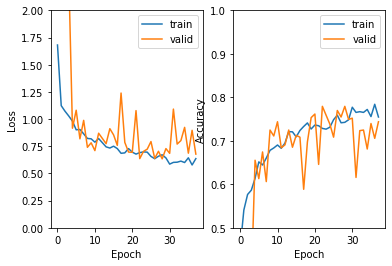

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

Il problema dell'overfitting è diminuito ma ancora sussistente e anche quello della varianza dei valori di accuracy del validation. Tuttavia il valore dell'accuracy risulta ancora contenuto e per questo migliorabile. 

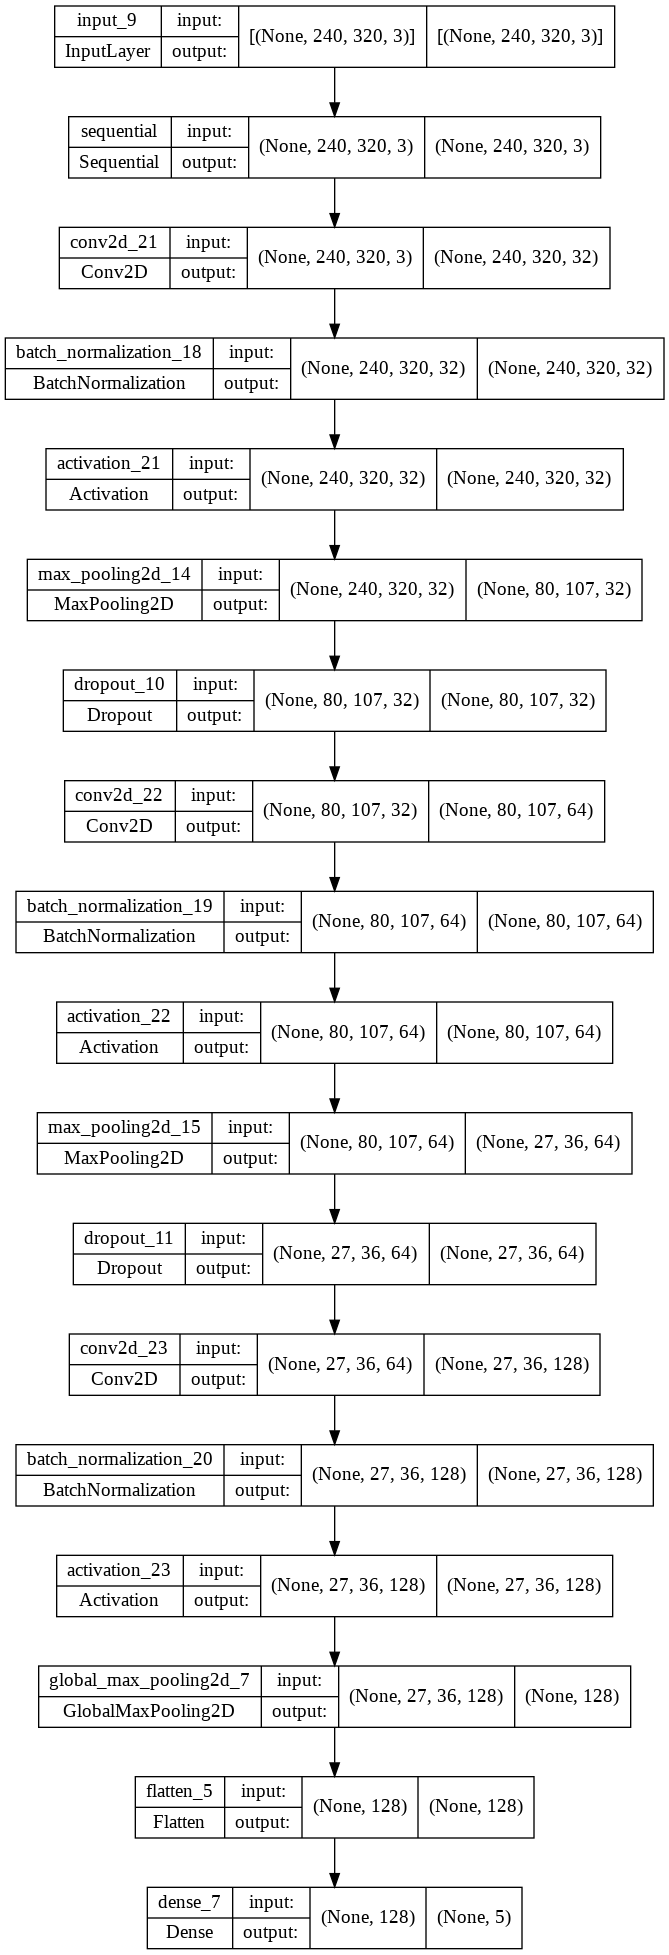

In [ ]:
plot_model(net3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
net3.save('net3')

# **RETE 4**

In quest'ultima rete si è individuato il miglior valore della batch_size per via simulativa. 
É stato aggiunto un kernel_initializer, che definisce come impostare i pesi inziali in maniera randomica, e un kernel_regulizer al fine di applicare penalizzazioni ai parametri durante l'ottimizzazione.
Infine, dopo numerose simulazioni si è ritenuto opportuno aumentare il numero delle epoche da 50 a 60. 

In [ ]:
inputs = keras.Input((240,320,3))

x = inputs


x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer=initializers.HeUniform(seed=1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('LeakyReLU')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.55) (x)

x = keras.layers.Conv2D(64, 3, padding="same",kernel_initializer=initializers.HeUniform(seed=1) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('LeakyReLU')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)
x = keras.layers.Dropout(0.55)(x)

x = keras.layers.Conv2D(128, 3, padding='same',kernel_initializer=initializers.HeUniform(seed=1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('LeakyReLU')(x)

x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Flatten()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer='l2',  kernel_initializer=initializers.HeUniform(seed=1))(x) 

net4 = keras.Model(inputs, outputs)

Utilizziamo ora l'algoritmo GridSearchCV per decidere quale sia la batch size ottimale

In [ ]:
def create_model():

    #definizione modello
    model = keras.Model(inputs, outputs) #Il modello è quello della cella precedente: net4
    
    # compilazione
    model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(0.005),
              metrics=['accuracy'])
    
    return model

In [ ]:
seed = 7
np.random.seed(seed)
batch_size = 128
epochs = 10

model_CV = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=1)

# definiamo l'insieme di batch sizes tra cui scegliere
batch_size = [16, 32, 64]

param_grid = dict(batch_size=batch_size)

grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, cv=2)
grid_result = grid.fit(x_train, y_train)

In [ ]:
print(f'Best Accuracy using {grid_result.best_params_}')

Useremo quindi batch_size=64

In [ ]:
net4.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(0.005),
              metrics=['accuracy'])

In [ ]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(base_path,
                                                                   image_size= (240,320),
                                                                   batch_size = 64,
                                                                   label_mode = 'categorical',
                                                                   color_mode = 'rgb',
                                                                   subset = 'training',
                                                                   validation_split = 0.2,
                                                                   shuffle =True,
                                                                   seed = 1)

validation_set = tf.keras.preprocessing.image_dataset_from_directory(base_path,
                                                                   image_size= (240,320),
                                                                   batch_size = 64,
                                                                   label_mode = 'categorical',
                                                                   color_mode = 'rgb',
                                                                   subset = 'validation',
                                                                   validation_split = 0.2,
                                                                   shuffle =True,
                                                                   seed = 1)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 15)
history = net4.fit(training_set, epochs=60, validation_data = validation_set, callbacks=[callback])

Epoch 1/60
46/46 [==============================] - 24s 232ms/step - loss: 1.8758 - accuracy: 0.4183 - val_loss: 4.9697 - val_accuracy: 0.3815
Epoch 2/60
46/46 [==============================] - 10s 206ms/step - loss: 1.1585 - accuracy: 0.5681 - val_loss: 2.3783 - val_accuracy: 0.4523
Epoch 3/60
46/46 [==============================] - 10s 205ms/step - loss: 1.1181 - accuracy: 0.5995 - val_loss: 1.0463 - val_accuracy: 0.6104
Epoch 4/60
46/46 [==============================] - 10s 205ms/step - loss: 1.0340 - accuracy: 0.6298 - val_loss: 1.0608 - val_accuracy: 0.5967
Epoch 5/60
46/46 [==============================] - 10s 205ms/step - loss: 1.0023 - accuracy: 0.6298 - val_loss: 0.8898 - val_accuracy: 0.7030
Epoch 6/60
46/46 [==============================] - 10s 207ms/step - loss: 0.9243 - accuracy: 0.6689 - val_loss: 1.0036 - val_accuracy: 0.6458
Epoch 7/60
46/46 [==============================] - 10s 207ms/step - loss: 0.9167 - accuracy: 0.6744 - val_loss: 0.8758 - val_accuracy: 0.7193

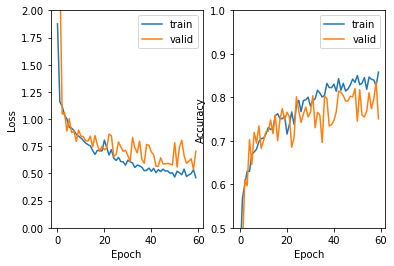

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

In [ ]:
net4.save('net4')

# **Matrice di confusione**



Con la seguente matrice si è voluta controllare l'accuratezza del modello nel classificare le immagini. Si può notare che il modello lavora in maniera soddisfacente e che la classe che viene classificata con più errori è "tulip".

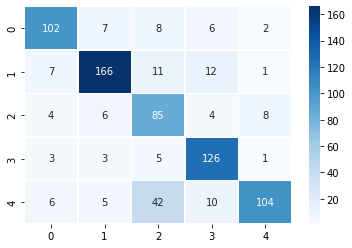

In [ ]:
predictions = np.array([])
labels =  np.array([])

for x, y in validation_set:

  predictions = np.concatenate([predictions, np.argmax(net4.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

sns.heatmap(confusion_matrix(labels, predictions), annot=True, fmt = '.0f',linewidths=.5,  cmap='Blues');

In [ ]:
mat = confusion_matrix(labels, predictions)

# **Performance del modello**

In [ ]:
wrong=[]
i=-1
for row in mat:
  k=0
  i=i+1
  h=-1
  for j in row:
    h=h+1
    if h!=i:
      k=k+j
  wrong.append(k)


wrong  

[23, 31, 22, 12, 63]

In [ ]:
right=[]
i=-1
for row in mat:
  k=0
  i=i+1
  h=-1
  for j in row:
    h=h+1
    if h==i:
      k=k+j
  right.append(k)

In [ ]:
graph = []
for i in range(0, len(wrong)):
  graph.append(100*right[i]/(right[i]+wrong[i]))
graph

[81.6,
 84.26395939086295,
 79.4392523364486,
 91.30434782608695,
 62.275449101796404]

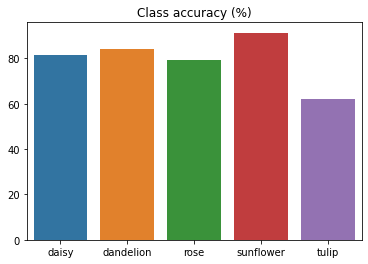

In [ ]:
fig = sns.barplot(x = ['daisy', 'dandelion', 'rose','sunflower', 'tulip'], y = graph)
fig.set(title = "Class accuracy (%)");

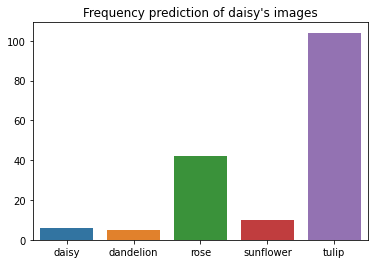

In [ ]:
fig = sns.barplot(x = ['daisy', 'dandelion', 'rose','sunflower', 'tulip'], y = mat[4])
fig.set(title = "Frequency prediction of daisy's images");

# **Visualizzazione delle previsioni del modello**

In [ ]:


t=(predictions - labels != 0)
idx=[i for i, x in enumerate(t) if x==True] 
li=itemgetter(idx)(np.array(validation_set.file_paths))


fig, axes = plt.subplots(2, 3, figsize = (14,14))
axes = axes.ravel() 


for i in np.arange(0, 6):
  for x in np.random.choice(li, 1):

    img = Image.open(x,"r")
    plt.imshow(img)
    label=x.split("/")[2] #giusto
    pred=itemgetter(int(itemgetter([i for i, e in enumerate(li) if e == x])(predictions)))(classes)
    axes[i].imshow(img)
    axes[i].set_title("Predicted Flower: "+pred +"\n"+ "Actual Flower: "+label, fontsize = 8) 
    axes[i].axis('off')


# **Classificazione immagini presa da Internet**





In questa fase è stata predetta un'immagine presa da Google raffigurante un girasole che è la classe che il modello predice con un'accuracy migliore

In [ ]:
classes = ["daisy",  "dandelion", "roses", "sunflowers" , "tulips"]

In [ ]:
random_seed = ()
sunflower_url = "https://www.kidsdogardening.com/wp-content/uploads/2020/03/AdobeStock_45549555-scaled.jpeg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    
    sunflower_path, target_size=(240,320 )
    
    )

img_array = keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = net4.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(
    "Questa immagine viene classificata con il",100 * np.max(score),"% come {}"
    .format(classes[np.argmax(score)])
)


Questa immagine viene classificata con il 40.4281884431839 % come sunflowers


In [ ]:
predictions

array([[6.66983533e-06, 1.06489391e-03, 1.16236615e-05, 9.98911500e-01,
        5.25502765e-06]], dtype=float32)

In [ ]:
score 


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.14888997, 0.14904761, 0.1488907 , 0.40428188, 0.14888975],
      dtype=float32)>

Di seguito, invece, è stata usata predetta un'immagine raffigurante un tulipano che rappresenta la classe con l'accuracy peggiore. 



In [ ]:

tulip_url = "https://www.giardinaggio.it/bulbi/tulipano_O4.jpg"
tulip_path = tf.keras.utils.get_file('Rose_tulip', origin=tulip_url)

img = keras.preprocessing.image.load_img(
    
    tulip_path, target_size=(240,320 )
    
    )

img_array = keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = net4.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(
    "Questa immagine viene classificata con il",100 * np.max(score),"% come {}"
    .format(classes[np.argmax(score)])
)


344064/334999 [==============================] - 2s 6us/step
Questa immagine viene classificata con il 26.842093467712402 % come roses


# **Transfer learning**

Questo metodo prevede l’utilizzo di reti addestrate, ad esempio su ImageNet, e si trovano dei metodi/procedure per trasferire la conoscenza acquisita su uno specifico task in un altro problema.

In [ ]:

num_classes = 5
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create model
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Do not train first layer (ResNet) as it is already pre-trained
model.layers[0].trainable = False

# Compile model
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


Creazione del modello

In [ ]:
num_classes = 5
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create model
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Do not train first layer (ResNet) as it is already pre-trained
model.layers[0].trainable = False

# Compile model
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Splitting dei dati in train e validation set

In [ ]:
train_folder = 'datasets/flower_photos/'

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(240, 320),
    batch_size=32,
    class_mode='categorical',
    subset='training'
    )
validation_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(240, 320),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
    )

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [ ]:
NUM_EPOCHS = 40
EARLY_STOP_PATIENCE = 15

In [ ]:

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5',
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  mode = 'auto')

In [ ]:
import math

fit_history = model.fit(
    train_generator,
    steps_per_epoch=20,
    validation_data=validation_generator,
    validation_steps=20,
    epochs=NUM_EPOCHS,
    callbacks=[cb_checkpointer, cb_early_stopper])
model.load_weights("../working/best.hdf5")

Epoch 1/40
20/20 [==============================] - 34s 2s/step - loss: 1.2367 - accuracy: 0.5797 - val_loss: 0.5314 - val_accuracy: 0.8188
Epoch 2/40
20/20 [==============================] - 26s 1s/step - loss: 0.5446 - accuracy: 0.7859 - val_loss: 0.4341 - val_accuracy: 0.8453
Epoch 3/40
20/20 [==============================] - 25s 1s/step - loss: 0.4226 - accuracy: 0.8438 - val_loss: 0.4853 - val_accuracy: 0.8406
Epoch 4/40
20/20 [==============================] - 31s 2s/step - loss: 0.4651 - accuracy: 0.8375 - val_loss: 0.4512 - val_accuracy: 0.8562
Epoch 5/40
20/20 [==============================] - 25s 1s/step - loss: 0.4178 - accuracy: 0.8547 - val_loss: 0.3460 - val_accuracy: 0.8813
Epoch 6/40
20/20 [==============================] - 24s 1s/step - loss: 0.3876 - accuracy: 0.8672 - val_loss: 0.3633 - val_accuracy: 0.8703
Epoch 7/40
20/20 [==============================] - 29s 1s/step - loss: 0.3271 - accuracy: 0.8953 - val_loss: 0.3260 - val_accuracy: 0.8875
Epoch 8/40
20/20 [==

In [ ]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


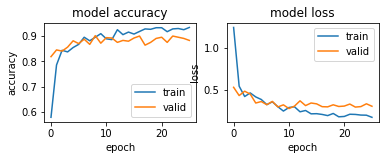

In [ ]:
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

Come si può notare dal grafico, l'utilizzo di questo metodo permette di ottenere risultati molto soddisfacenti con un costo computazionale minimo